# Introduction



---



---



In this notebook, we will implement the following tests for the LINEAR MADDEN PROBLEM:


a) For each epsilon:

i) Until mesh convergence

- Physical solve based on current mesh
- Compute the L2 and H1 errors in the physical solution
- Compute Hessian M based on the current physical solution and mesh, take $\alpha_{hat} = \epsilon^{-3/4}$ (for $m=0$) or $\alpha_{hat} = \epsilon^{-5/4}$ (for $m=1$)
- Perform a mesh solve
- Continuation in $u$ and $x$

ii) Continuation in $u$ and $x$

b) Compare errors, solutions, etc


# Where Do These Scalings Come From?


---



---



I will work it out in the L2 case and leave the H1 case for the reader (lol).


## Step 1 - From my "Exploring_M_and_Epsilon_Relationship" notebook:





- This notebook shows us that the L1 norm of $|u''|$ behaves like $\frac{1}{\epsilon}.$ Thus, $|u''|$ behaves like $\frac{1}{\epsilon^2}.$

- To see this, note that the L1 norm of $|u''|$ is $$ \text{L1 Norm} = \text{width} \times |u''|  \approx \frac{1}{\epsilon}.$$
$$ (\text{width} = \epsilon)  \times |u''|  \approx \frac{1}{\epsilon}.$$
For this to be true, $$ | u'' | \approx \frac{1}{\epsilon^2}.$$


## Step 2 - The Scaling on $|u''|$ in $M$





In the L2 case, I formulate $M$ as $M = ( 1 + \frac{1}{\alpha} |u''| )^{4/5}.$ We want the integral of $M$ to be $O(1).$ Thus, we want
$$ \text{width} = \epsilon \times M \approx 1$$
or
$$ M \approx \epsilon^{-1}.$$

Based on Step 1, we have

$$ \left(\frac{1}{\alpha} |u''| \right)^{4/5} \approx \epsilon^{-1} $$
$$ \left(\frac{1}{\alpha} \epsilon^{-2} \right)^{4/5} \approx \epsilon^{-1} $$
$$ \left(\frac{1}{\alpha} \epsilon^{-2} \right) \approx \epsilon^{-5/4} $$
$$ \left(\frac{1}{\alpha}\right) \approx \epsilon^{-5/4} \epsilon^{2} = \epsilon^{3/4}.$$

Thus, we take

$$ \alpha = \text{constant} \times \epsilon^{-3/4}.$$

# Results and Comments


---



---

- Results look good!

- Mesh solve is in CG1 and physical solve is in CG4. When I set these both to be in CG2 my MP-Iteration seemed to oversolve itself and endup with a horrible mesh. I am not sure why changing the function space fixed this issue.

-  Improvement upon notebook called 'EpsilonScaledAlpha_GaussSiedal_MPIteration_LinearProblem.ipynb' because here I implement the desired mesh_tol = (1/10)epsilon. Now, the stopping criteria on the MP-Iteration is norm(mesh difference) < (1/10)epsilon.

In [1]:
# install firedrake

# hide output
%%capture

try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# Setup

In [4]:
# SETUP

# Mesh and space
N = 50
xi_mesh = UnitIntervalMesh(N)
V_mesh = FunctionSpace(xi_mesh, 'CG', 1)
V_phys = FunctionSpace(xi_mesh, "CG", 4)
V_residual = FunctionSpace(xi_mesh, "R", 0)
x = Function(V_mesh).interpolate(SpatialCoordinate(xi_mesh)[0])
perm_x =  np.argsort(x.dat.data[:])



# Solver paramaters


newton_params = {
        'snes_type': 'newtonls',
        # 'snes_monitor': None,
        # "snes_converged_reason": None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'l2',
        # 'snes_linesearch_monitor': None,
        'snes_linesearch_damping': 0.5,
        'pc_type' : 'lu',
        'snes_rtol': 1e-8,
        'snes_stol': 1e-8,
        'snes_max_it': 100,
}


lu_params = {
    'snes_type': 'ksponly',
    # 'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}

# Numerical Test



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.1 MESH TOLERANCE FOR MP-ITERATION IS 0.010000000000000002
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.5773502691896256
norm(u) =  1.0408329997330663



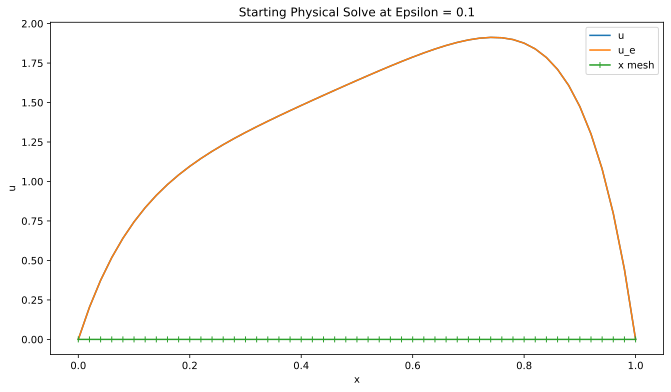



  0 SNES Function norm 1.683803766101e+00
  1 SNES Function norm 1.284640324219e-05
  0 SNES Function norm 6.961005565268e-01
  1 SNES Function norm 5.310825779404e-06
  0 SNES Function norm 3.203230336790e-01
  1 SNES Function norm 2.443870803279e-06
  0 SNES Function norm 2.007116629768e-01
  1 SNES Function norm 1.531308464808e-06
  0 SNES Function norm 1.554771596982e-01
  1 SNES Function norm 1.186196590424e-06
  0 SNES Function norm 1.238412551297e-01
  1 SNES Function norm 9.448337943246e-07
  0 SNES Function norm 9.658597989100e-02
  1 SNES Function norm 7.368925465667e-07
  0 SNES Function norm 7.358513848260e-02
  1 SNES Function norm 5.614100525798e-07

SINCE MESH TOLERANCE =  0.008518490619111651 WE HAVE MESH CONVERGENCE IN 8 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
94.8041

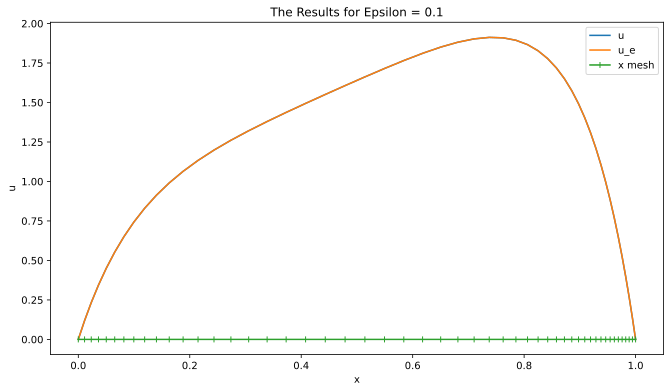



Epsilon continuation checks
norm(x) =  0.6671242179622308
norm(u) =  1.3129970295491549



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.07500000000000001 MESH TOLERANCE FOR MP-ITERATION IS 0.0075000000000000015
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6671242179622308
norm(u) =  1.3129970295491549



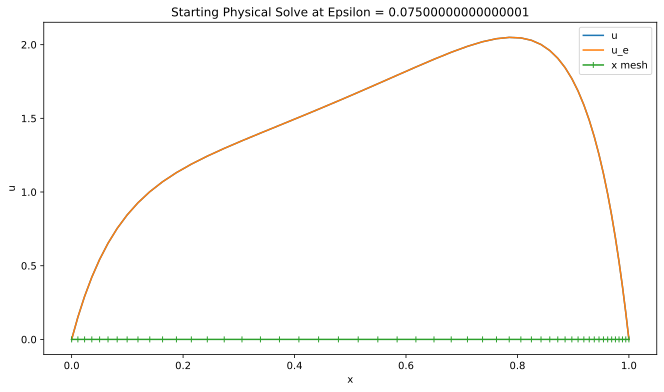



  0 SNES Function norm 2.620169318549e-01
  1 SNES Function norm 1.999030546078e-06
  0 SNES Function norm 1.309012536352e-01
  1 SNES Function norm 9.986973080913e-07
  0 SNES Function norm 8.488431149250e-02
  1 SNES Function norm 6.476159008223e-07

SINCE MESH TOLERANCE =  0.006308681672656846 WE HAVE MESH CONVERGENCE IN 3 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
43.44313442330113, 38.46171827277616, 36.24366550149035, 

ERRORS:
L2 error is 4.9012083494114616e-09
Energy norm error is 6.315232186364395e-09

PLOTS:


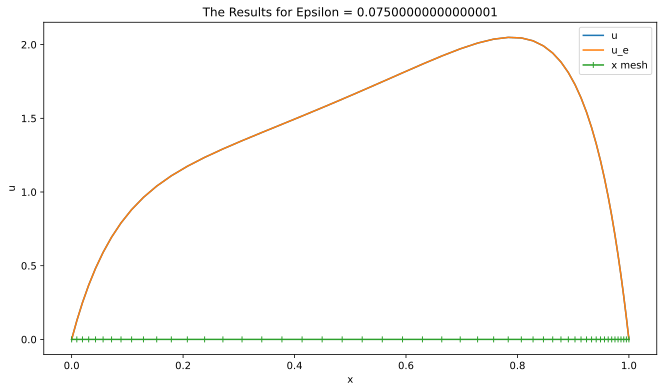



Epsilon continuation checks
norm(x) =  0.6763777545817762
norm(u) =  1.3904165396159192



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.05625000000000001 MESH TOLERANCE FOR MP-ITERATION IS 0.0056250000000000015
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6763777545817762
norm(u) =  1.3904165396159192



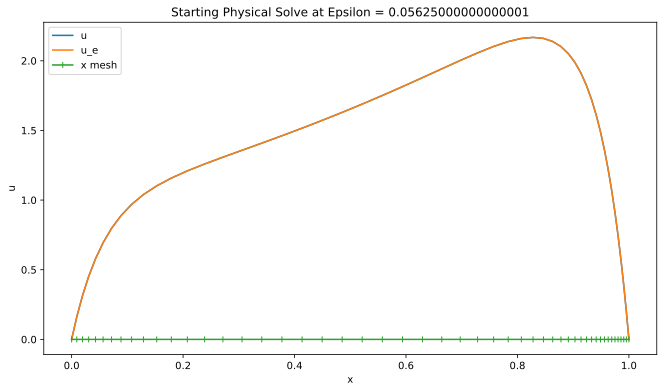



  0 SNES Function norm 3.352075861158e-01
  1 SNES Function norm 2.557430923439e-06
  0 SNES Function norm 1.809616492113e-01
  1 SNES Function norm 1.380627816980e-06
  0 SNES Function norm 1.263099196221e-01
  1 SNES Function norm 9.636682088511e-07
  0 SNES Function norm 1.019647618062e-01
  1 SNES Function norm 7.779293955478e-07

SINCE MESH TOLERANCE =  0.005014372855098571 WE HAVE MESH CONVERGENCE IN 4 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
45.56144551142672, 39.72476126400425, 37.077721571052635, 35.99563958267331, 

ERRORS:
L2 error is 1.436402035088131e-08
Energy norm error is 1.839981266674355e-08

PLOTS:


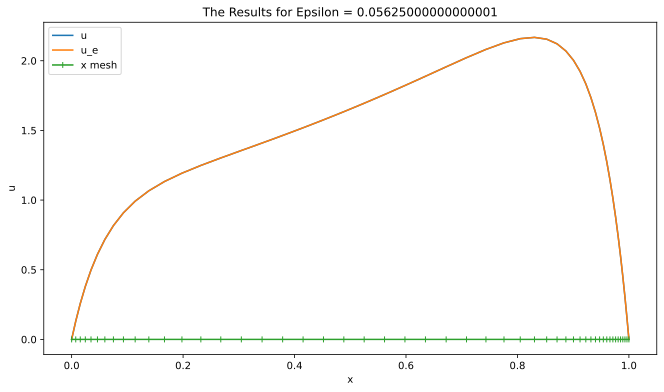



Epsilon continuation checks
norm(x) =  0.685207860602685
norm(u) =  1.4408896806800329



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0421875 MESH TOLERANCE FOR MP-ITERATION IS 0.00421875
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.685207860602685
norm(u) =  1.4408896806800329



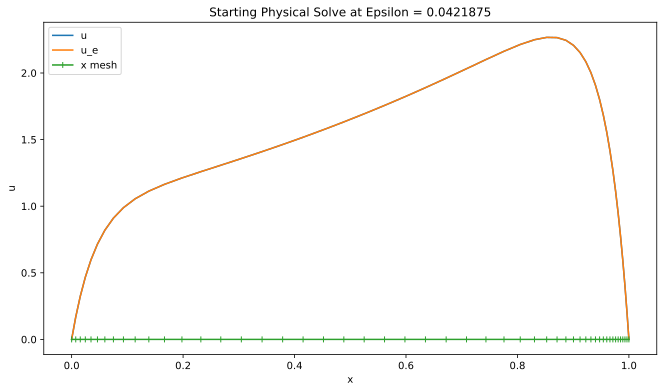



  0 SNES Function norm 3.637738616529e-01
  1 SNES Function norm 2.775374311078e-06
  0 SNES Function norm 2.046828678265e-01
  1 SNES Function norm 1.561606352563e-06
  0 SNES Function norm 1.505986562914e-01
  1 SNES Function norm 1.148976564919e-06
  0 SNES Function norm 1.296852674513e-01
  1 SNES Function norm 9.894200688570e-07
  0 SNES Function norm 1.146685872789e-01
  1 SNES Function norm 8.748518917066e-07

SINCE MESH TOLERANCE =  0.0039977037004830795 WE HAVE MESH CONVERGENCE IN 5 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
46.296772971042344, 40.41451402234532, 37.6871426770914, 36.5446931037476, 36.16636253162318, 

ERRORS:
L2 error is 4.144593555137366e-08
Energy norm error is 5.3079151103114655e-08

PLOTS:


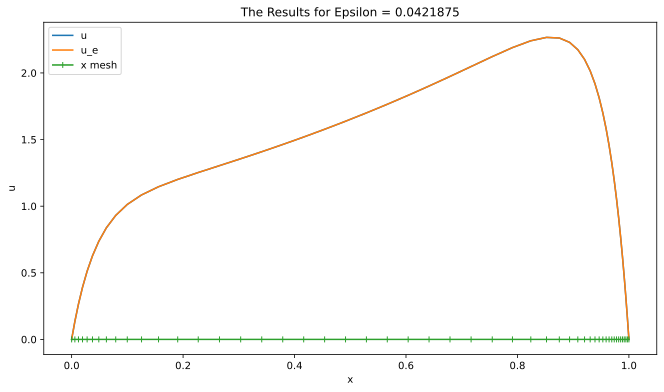



Epsilon continuation checks
norm(x) =  0.6928817657631229
norm(u) =  1.4799594332196515



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.031640625000000006 MESH TOLERANCE FOR MP-ITERATION IS 0.0031640625000000006
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6928817657631229
norm(u) =  1.4799594332196515



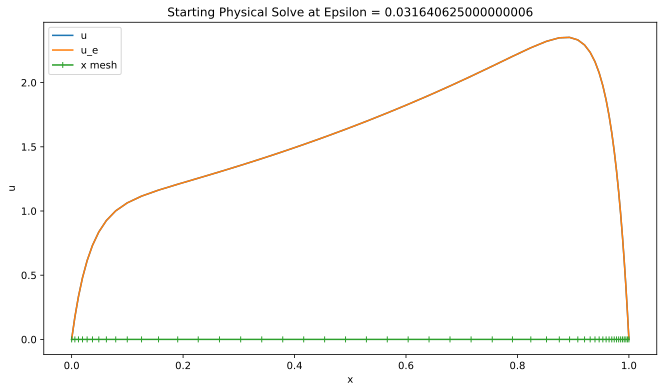



  0 SNES Function norm 4.083250948173e-01
  1 SNES Function norm 3.115273247653e-06
  0 SNES Function norm 2.363943684098e-01
  1 SNES Function norm 1.803545901517e-06
  0 SNES Function norm 1.752160936199e-01
  1 SNES Function norm 1.336792703333e-06
  0 SNES Function norm 1.565942439993e-01
  1 SNES Function norm 1.194719271444e-06
  0 SNES Function norm 1.478743897487e-01
  1 SNES Function norm 1.128192060650e-06
  0 SNES Function norm 1.363488884119e-01
  1 SNES Function norm 1.040259462683e-06
  0 SNES Function norm 1.205856937885e-01
  1 SNES Function norm 9.199958338088e-07

SINCE MESH TOLERANCE =  0.002802672772209316 WE HAVE MESH CONVERGENCE IN 7 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
47.19864067332373, 41.18067516066198, 38.31013189696574, 37.0589341803686, 36.6140217107779

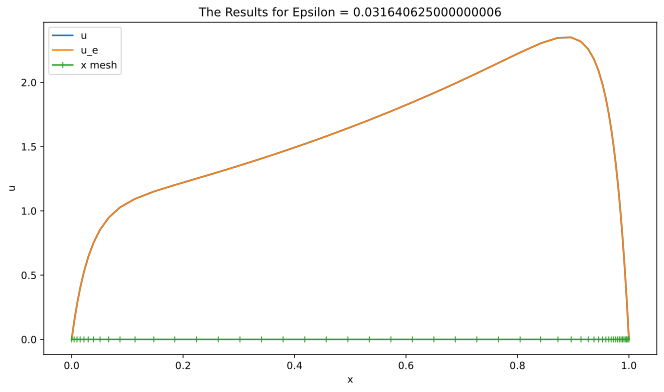



Epsilon continuation checks
norm(x) =  0.699912050710182
norm(u) =  1.5120510580391844



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.023730468750000004 MESH TOLERANCE FOR MP-ITERATION IS 0.0023730468750000006
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.699912050710182
norm(u) =  1.5120510580391844



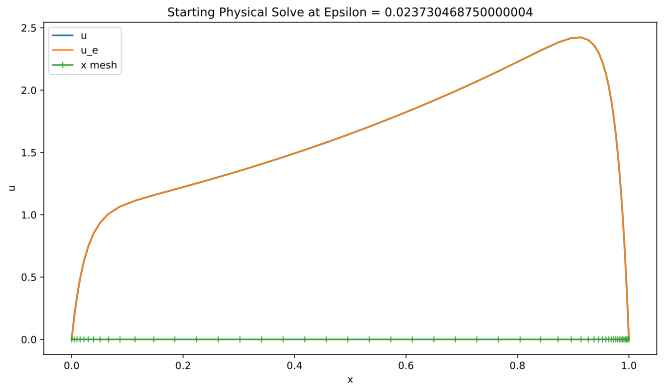



  0 SNES Function norm 4.836164918710e-01
  1 SNES Function norm 3.689701013476e-06
  0 SNES Function norm 2.966210409414e-01
  1 SNES Function norm 2.263038945906e-06
  0 SNES Function norm 2.139086612285e-01
  1 SNES Function norm 1.631993569028e-06
  0 SNES Function norm 1.841353931201e-01
  1 SNES Function norm 1.404841559295e-06
  0 SNES Function norm 1.779588251358e-01
  1 SNES Function norm 1.357718089380e-06
  0 SNES Function norm 1.744281116576e-01
  1 SNES Function norm 1.330780878410e-06
  0 SNES Function norm 1.647619717807e-01
  1 SNES Function norm 1.257034084172e-06
  0 SNES Function norm 1.481226140370e-01
  1 SNES Function norm 1.130085860112e-06

SINCE MESH TOLERANCE =  0.0023251537965095644 WE HAVE MESH CONVERGENCE IN 8 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
48.261

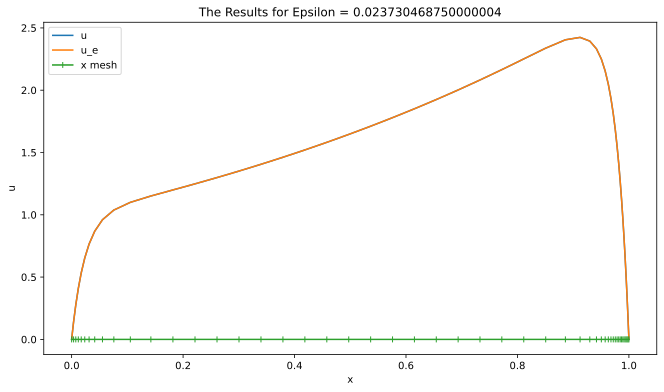



Epsilon continuation checks
norm(x) =  0.7047552605778419
norm(u) =  1.537196943482751



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0177978515625 MESH TOLERANCE FOR MP-ITERATION IS 0.0017797851562500002
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7047552605778419
norm(u) =  1.537196943482751



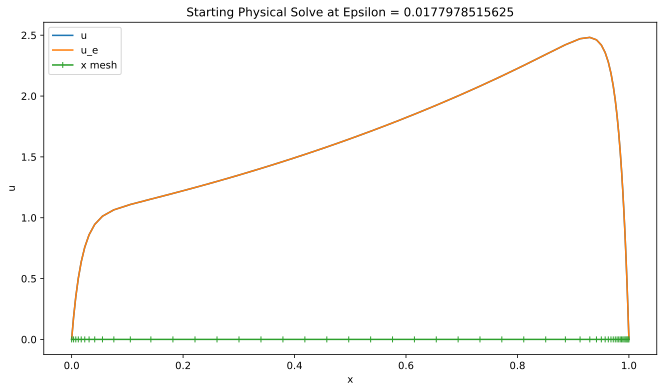



  0 SNES Function norm 5.607775326137e-01
  1 SNES Function norm 4.278393048010e-06
  0 SNES Function norm 3.727409790145e-01
  1 SNES Function norm 2.843787984858e-06
  0 SNES Function norm 2.732177192309e-01
  1 SNES Function norm 2.084485771357e-06
  0 SNES Function norm 2.305169895386e-01
  1 SNES Function norm 1.758705055178e-06
  0 SNES Function norm 2.259434546741e-01
  1 SNES Function norm 1.723811756033e-06
  0 SNES Function norm 2.333902095612e-01
  1 SNES Function norm 1.780625987958e-06
  0 SNES Function norm 2.345757541336e-01
  1 SNES Function norm 1.789670973790e-06
  0 SNES Function norm 2.225480677740e-01
  1 SNES Function norm 1.697907011457e-06
  0 SNES Function norm 1.988073173025e-01
  1 SNES Function norm 1.516779458830e-06
  0 SNES Function norm 1.689242638672e-01
  1 SNES Function norm 1.288789859955e-06

SINCE MESH TOLERANCE =  0.0017495481095039468 WE HAVE MESH CONVERGENCE IN 10 MP ITERATIONS


________________________________________________________________

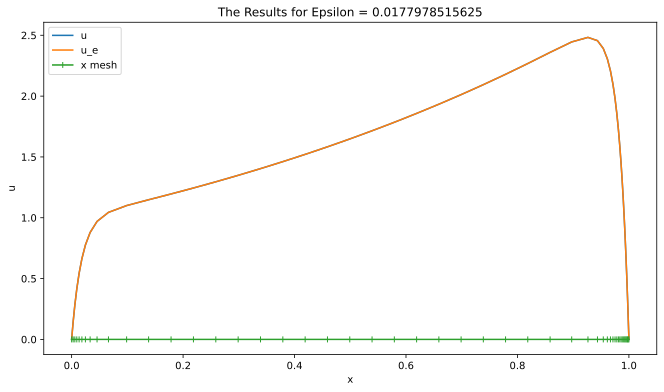



Epsilon continuation checks
norm(x) =  0.7089548866530291
norm(u) =  1.5580570321015983



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.013348388671875001 MESH TOLERANCE FOR MP-ITERATION IS 0.0013348388671875003
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7089548866530291
norm(u) =  1.5580570321015983



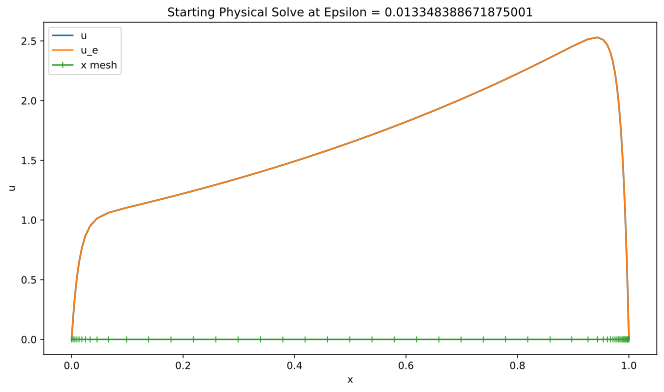



  0 SNES Function norm 6.687786505985e-01
  1 SNES Function norm 5.102376180447e-06
  0 SNES Function norm 4.882255237296e-01
  1 SNES Function norm 3.724865140431e-06
  0 SNES Function norm 3.691525453483e-01
  1 SNES Function norm 2.816410411372e-06
  0 SNES Function norm 2.983466450821e-01
  1 SNES Function norm 2.276204269087e-06
  0 SNES Function norm 2.803732593060e-01
  1 SNES Function norm 2.139078213615e-06
  0 SNES Function norm 2.954805741276e-01
  1 SNES Function norm 2.254337873430e-06
  0 SNES Function norm 3.142129227926e-01
  1 SNES Function norm 2.397254355795e-06
  0 SNES Function norm 3.180631883473e-01
  1 SNES Function norm 2.426629559742e-06
  0 SNES Function norm 3.021866077958e-01
  1 SNES Function norm 2.305500852369e-06
  0 SNES Function norm 2.693536033161e-01
  1 SNES Function norm 2.055004913309e-06
  0 SNES Function norm 2.267466842109e-01
  1 SNES Function norm 1.729939907764e-06
  0 SNES Function norm 1.818082120084e-01
  1 SNES Function norm 1.3870865

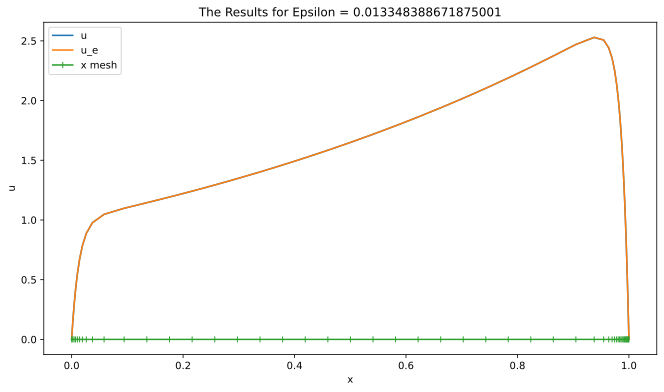



Epsilon continuation checks
norm(x) =  0.7121704539077691
norm(u) =  1.5746267679475598



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.01001129150390625 MESH TOLERANCE FOR MP-ITERATION IS 0.001001129150390625
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7121704539077691
norm(u) =  1.5746267679475598



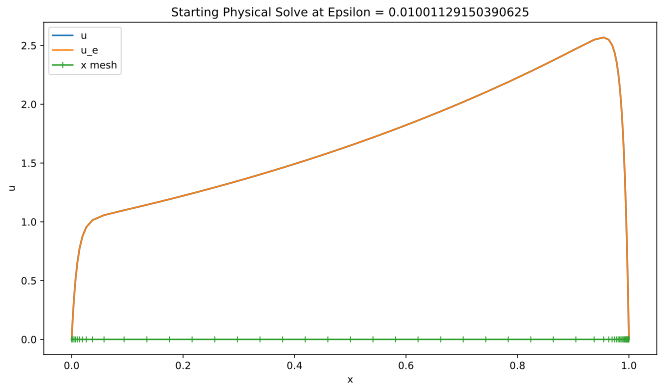



  0 SNES Function norm 7.920817573699e-01
  1 SNES Function norm 6.043104224802e-06
  0 SNES Function norm 6.260727033959e-01
  1 SNES Function norm 4.776555658609e-06
  0 SNES Function norm 4.911441305018e-01
  1 SNES Function norm 3.747132343476e-06
  0 SNES Function norm 3.925707458006e-01
  1 SNES Function norm 2.995077094807e-06
  0 SNES Function norm 3.543020190901e-01
  1 SNES Function norm 2.703109878202e-06
  0 SNES Function norm 3.706567076192e-01
  1 SNES Function norm 2.827886254170e-06
  0 SNES Function norm 4.029044704073e-01
  1 SNES Function norm 3.073917169830e-06
  0 SNES Function norm 4.249364622433e-01
  1 SNES Function norm 3.242007915309e-06
  0 SNES Function norm 4.290267572630e-01
  1 SNES Function norm 3.273214397732e-06
  0 SNES Function norm 4.082756322333e-01
  1 SNES Function norm 3.114895885520e-06
  0 SNES Function norm 3.662127554298e-01
  1 SNES Function norm 2.793981587638e-06
  0 SNES Function norm 3.081574291792e-01
  1 SNES Function norm 2.3510546

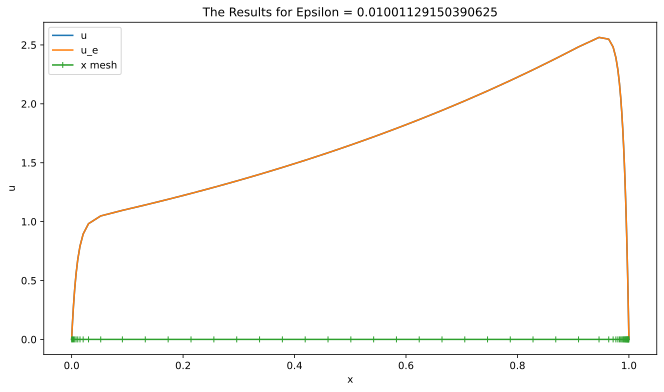



Epsilon continuation checks
norm(x) =  0.7146282967846437
norm(u) =  1.5876004105300918



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.007508468627929688 MESH TOLERANCE FOR MP-ITERATION IS 0.0007508468627929689
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7146282967846437
norm(u) =  1.5876004105300918



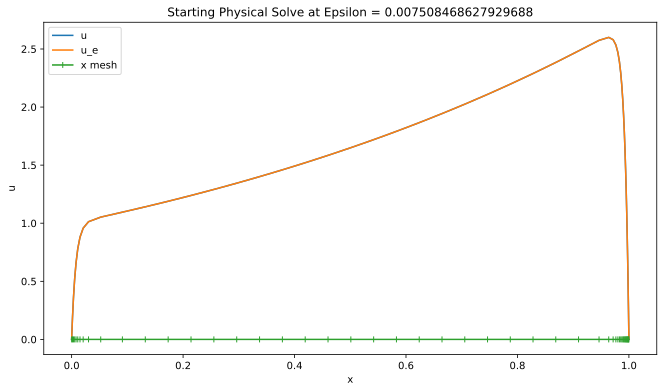



  0 SNES Function norm 9.247402744221e-01
  1 SNES Function norm 7.055208385776e-06
  0 SNES Function norm 7.855101317803e-01
  1 SNES Function norm 5.992966703769e-06
  0 SNES Function norm 6.293564367853e-01
  1 SNES Function norm 4.801608560629e-06
  0 SNES Function norm 4.975128270656e-01
  1 SNES Function norm 3.795721642409e-06
  0 SNES Function norm 4.374412986310e-01
  1 SNES Function norm 3.337412250239e-06
  0 SNES Function norm 4.587993758301e-01
  1 SNES Function norm 3.500361435257e-06
  0 SNES Function norm 5.123369653380e-01
  1 SNES Function norm 3.908820840484e-06
  0 SNES Function norm 5.459208403762e-01
  1 SNES Function norm 4.165045484712e-06
  0 SNES Function norm 5.469223576685e-01
  1 SNES Function norm 4.172686461695e-06
  0 SNES Function norm 5.281473361317e-01
  1 SNES Function norm 4.029444401431e-06
  0 SNES Function norm 4.988659012545e-01
  1 SNES Function norm 3.806044787691e-06
  0 SNES Function norm 4.563307159312e-01
  1 SNES Function norm 3.4815270

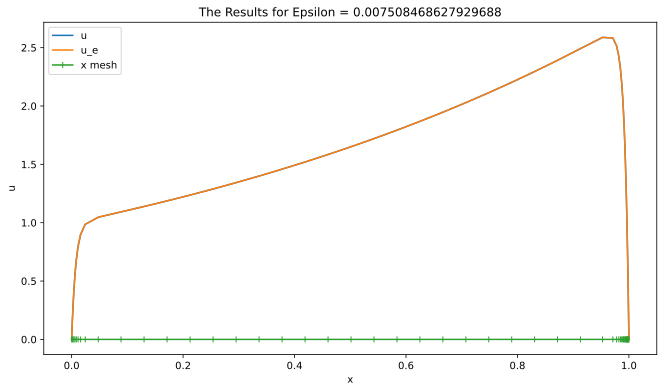



Epsilon continuation checks
norm(x) =  0.7164777379738818
norm(u) =  1.5974817526277885



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.005631351470947266 MESH TOLERANCE FOR MP-ITERATION IS 0.0005631351470947267
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7164777379738818
norm(u) =  1.5974817526277885



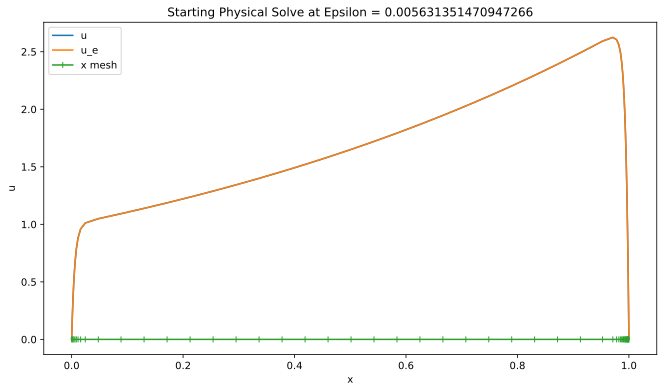



  0 SNES Function norm 1.068138555623e+00
  1 SNES Function norm 8.149250452218e-06
  0 SNES Function norm 9.187121602485e-01
  1 SNES Function norm 7.009217532054e-06
  0 SNES Function norm 7.403353894653e-01
  1 SNES Function norm 5.648310771035e-06
  0 SNES Function norm 5.848272406806e-01
  1 SNES Function norm 4.461877744291e-06
  0 SNES Function norm 5.061140938772e-01
  1 SNES Function norm 3.861344102498e-06
  0 SNES Function norm 5.340319779929e-01
  1 SNES Function norm 4.074340659640e-06
  0 SNES Function norm 6.309600795453e-01
  1 SNES Function norm 4.813843386050e-06
  0 SNES Function norm 7.166125096454e-01
  1 SNES Function norm 5.467319577351e-06
  0 SNES Function norm 7.372770804581e-01
  1 SNES Function norm 5.624977711142e-06
  0 SNES Function norm 6.923961911521e-01
  1 SNES Function norm 5.282563693763e-06
  0 SNES Function norm 6.180244294595e-01
  1 SNES Function norm 4.715152221557e-06
  0 SNES Function norm 5.465264346387e-01
  1 SNES Function norm 4.1696657

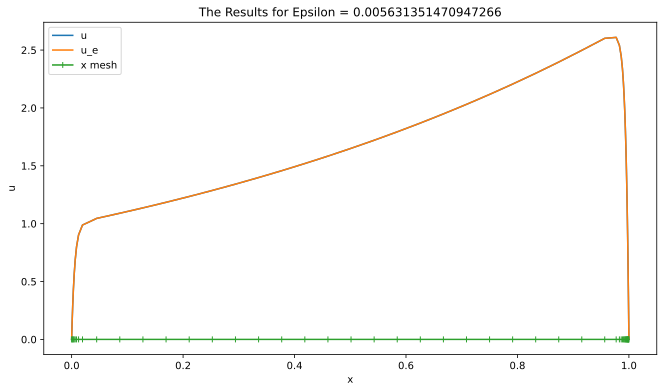



Epsilon continuation checks
norm(x) =  0.7178236677448782
norm(u) =  1.6046340196222637



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.004223513603210449 MESH TOLERANCE FOR MP-ITERATION IS 0.000422351360321045
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7178236677448782
norm(u) =  1.6046340196222637



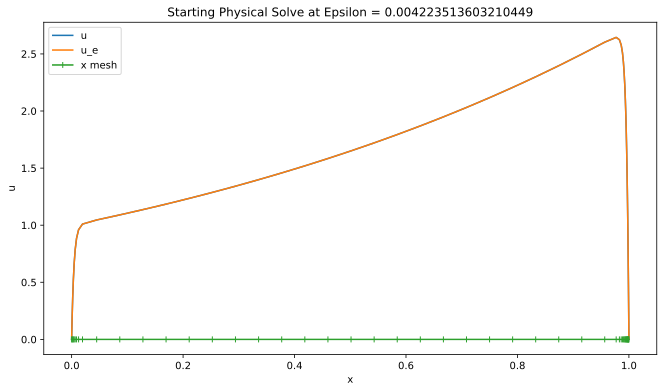



  0 SNES Function norm 1.124443352967e+00
  1 SNES Function norm 8.578821978852e-06
  0 SNES Function norm 9.883586784844e-01
  1 SNES Function norm 7.540578298096e-06
  0 SNES Function norm 8.257863857531e-01
  1 SNES Function norm 6.300250138501e-06
  0 SNES Function norm 6.773496252420e-01
  1 SNES Function norm 5.167767514708e-06
  0 SNES Function norm 5.772321512611e-01
  1 SNES Function norm 4.403931796974e-06
  0 SNES Function norm 5.803167778395e-01
  1 SNES Function norm 4.427465622008e-06
  0 SNES Function norm 6.979929207060e-01
  1 SNES Function norm 5.325263363949e-06
  0 SNES Function norm 8.574958438023e-01
  1 SNES Function norm 6.542174109205e-06
  0 SNES Function norm 9.666278735822e-01
  1 SNES Function norm 7.374785418785e-06
  0 SNES Function norm 9.715973037827e-01
  1 SNES Function norm 7.412699106001e-06
  0 SNES Function norm 8.789805144428e-01
  1 SNES Function norm 6.706089128130e-06
  0 SNES Function norm 7.339118332468e-01
  1 SNES Function norm 5.5993029

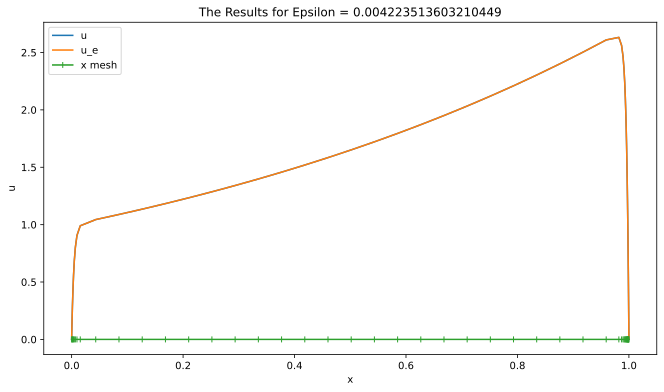



Epsilon continuation checks
norm(x) =  0.7189431018554695
norm(u) =  1.610598202977148



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0031676352024078373 MESH TOLERANCE FOR MP-ITERATION IS 0.00031676352024078374
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7189431018554695
norm(u) =  1.610598202977148



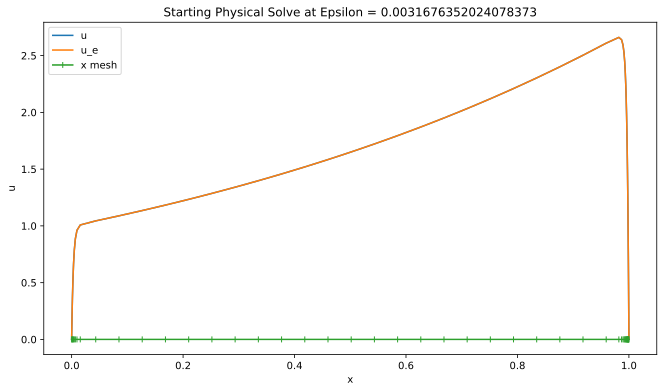



  0 SNES Function norm 1.156016186834e+00
  1 SNES Function norm 8.819703565065e-06
  0 SNES Function norm 1.052275222915e+00
  1 SNES Function norm 8.028222832535e-06
  0 SNES Function norm 9.450178339905e-01
  1 SNES Function norm 7.209913900532e-06
  0 SNES Function norm 8.184321812975e-01
  1 SNES Function norm 6.244141990952e-06
  0 SNES Function norm 6.976660350905e-01
  1 SNES Function norm 5.322769433142e-06
  0 SNES Function norm 6.524171549337e-01
  1 SNES Function norm 4.977547819710e-06
  0 SNES Function norm 7.345344530854e-01
  1 SNES Function norm 5.604053092366e-06
  0 SNES Function norm 9.225492735021e-01
  1 SNES Function norm 7.038492398780e-06
  0 SNES Function norm 1.127989862996e+00
  1 SNES Function norm 8.605879712719e-06
  0 SNES Function norm 1.252428617838e+00
  1 SNES Function norm 9.555272039576e-06
  0 SNES Function norm 1.239969885676e+00
  1 SNES Function norm 9.460219467619e-06
  0 SNES Function norm 1.100515532401e+00
  1 SNES Function norm 8.3962671

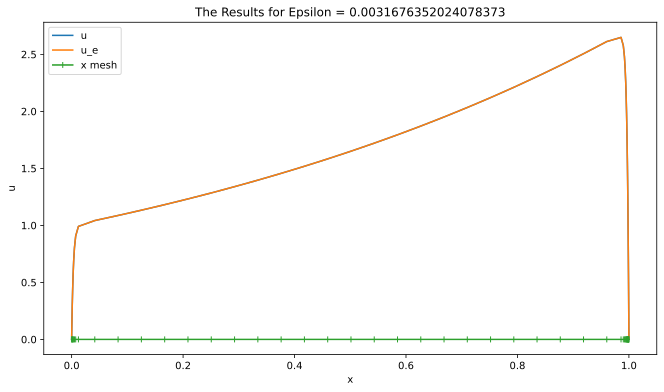



Epsilon continuation checks
norm(x) =  0.7195894085620986
norm(u) =  1.6142097398126785



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.002375726401805878 MESH TOLERANCE FOR MP-ITERATION IS 0.00023757264018058782
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7195894085620986
norm(u) =  1.6142097398126785



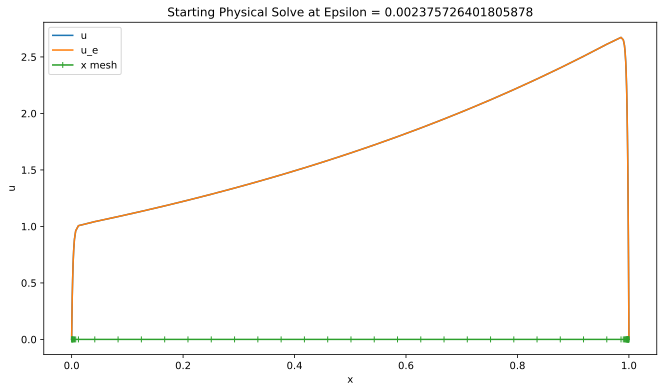



  0 SNES Function norm 1.163989684464e+00
  1 SNES Function norm 8.880536513972e-06
  0 SNES Function norm 1.138735849429e+00
  1 SNES Function norm 8.687865061269e-06
  0 SNES Function norm 1.093643797001e+00
  1 SNES Function norm 8.343840017369e-06
  0 SNES Function norm 9.875305220693e-01
  1 SNES Function norm 7.534259971496e-06
  0 SNES Function norm 8.476274070244e-01
  1 SNES Function norm 6.466883940014e-06
  0 SNES Function norm 7.593727607005e-01
  1 SNES Function norm 5.793554400185e-06
  0 SNES Function norm 7.802043082513e-01
  1 SNES Function norm 5.952486504135e-06
  0 SNES Function norm 9.273962713252e-01
  1 SNES Function norm 7.075472036341e-06
  0 SNES Function norm 1.167642806328e+00
  1 SNES Function norm 8.908407623646e-06
  0 SNES Function norm 1.403698324489e+00
  1 SNES Function norm 1.070936830427e-05
  0 SNES Function norm 1.536472222684e+00
  1 SNES Function norm 1.172235279413e-05
  0 SNES Function norm 1.517853445518e+00
  1 SNES Function norm 1.1580302

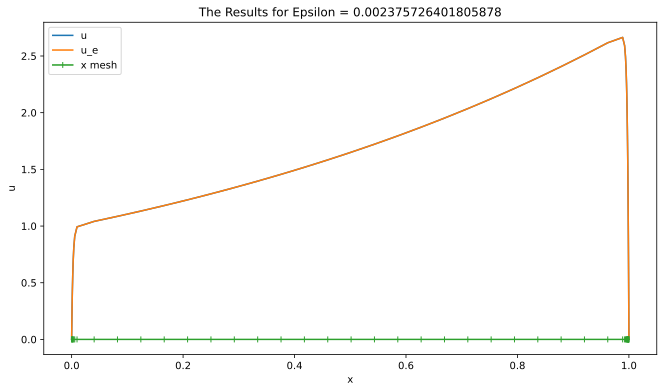



Epsilon continuation checks
norm(x) =  0.7202964589471212
norm(u) =  1.6184233075488181



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0017817948013544084 MESH TOLERANCE FOR MP-ITERATION IS 0.00017817948013544084
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7202964589471212
norm(u) =  1.6184233075488181



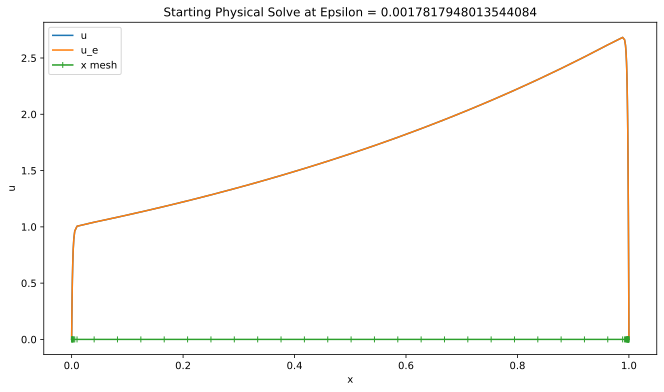



  0 SNES Function norm 1.217113715441e+00
  1 SNES Function norm 9.285840742687e-06
  0 SNES Function norm 1.246179304069e+00
  1 SNES Function norm 9.507593562230e-06
  0 SNES Function norm 1.257186251859e+00
  1 SNES Function norm 9.591569908908e-06
  0 SNES Function norm 1.165896389923e+00
  1 SNES Function norm 8.895083573728e-06
  0 SNES Function norm 9.889640235257e-01
  1 SNES Function norm 7.545196759555e-06
  0 SNES Function norm 7.967731684071e-01
  1 SNES Function norm 6.078896805935e-06
  0 SNES Function norm 8.302208730598e-01
  1 SNES Function norm 6.334082625349e-06
  0 SNES Function norm 9.967106813920e-01
  1 SNES Function norm 7.604299066296e-06
  0 SNES Function norm 1.144580572361e+00
  1 SNES Function norm 8.732456733264e-06
  0 SNES Function norm 1.356078520292e+00
  1 SNES Function norm 1.034605804361e-05
  0 SNES Function norm 1.607495343332e+00
  1 SNES Function norm 1.226421622146e-05
  0 SNES Function norm 1.748249855726e+00
  1 SNES Function norm 1.3338087

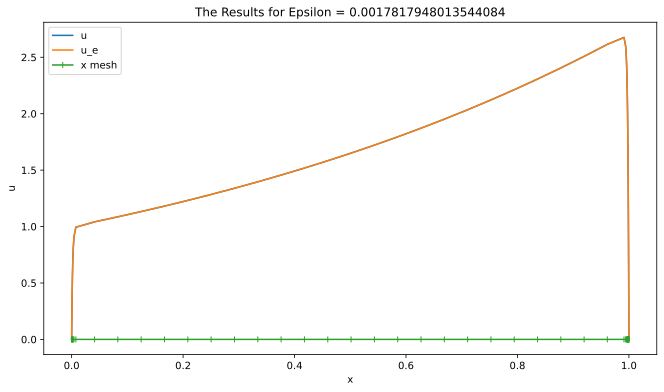



Epsilon continuation checks
norm(x) =  0.7205852492155947
norm(u) =  1.6191493830132164



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0013363461010158064 MESH TOLERANCE FOR MP-ITERATION IS 0.00013363461010158065
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7205852492155947
norm(u) =  1.6191493830132164



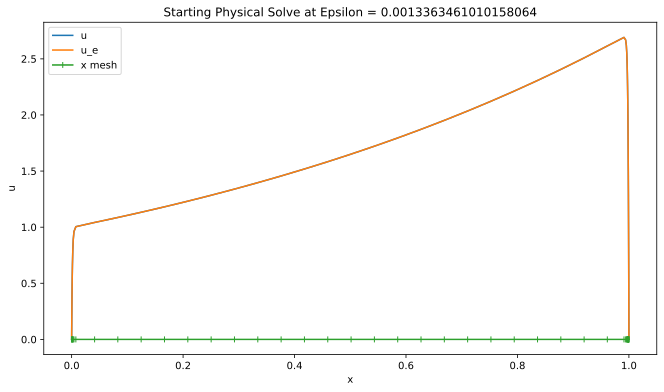



  0 SNES Function norm 1.221187455724e+00
  1 SNES Function norm 9.316920896349e-06
  0 SNES Function norm 1.326977412100e+00
  1 SNES Function norm 1.012403420181e-05
  0 SNES Function norm 1.389717580370e+00
  1 SNES Function norm 1.060270371146e-05
  0 SNES Function norm 1.315745885238e+00
  1 SNES Function norm 1.003834445631e-05
  0 SNES Function norm 1.007193978956e+00
  1 SNES Function norm 7.684280264972e-06
  0 SNES Function norm 8.261884494366e-01
  1 SNES Function norm 6.303317683283e-06
  0 SNES Function norm 8.185638669765e-01
  1 SNES Function norm 6.245146723872e-06
  0 SNES Function norm 9.895693795381e-01
  1 SNES Function norm 7.549815218124e-06
  0 SNES Function norm 1.260200576547e+00
  1 SNES Function norm 9.614567408448e-06
  0 SNES Function norm 1.445785804337e+00
  1 SNES Function norm 1.103047033688e-05
  0 SNES Function norm 1.421364217114e+00
  1 SNES Function norm 1.084414837551e-05
  0 SNES Function norm 1.662001915322e+00
  1 SNES Function norm 1.2680068

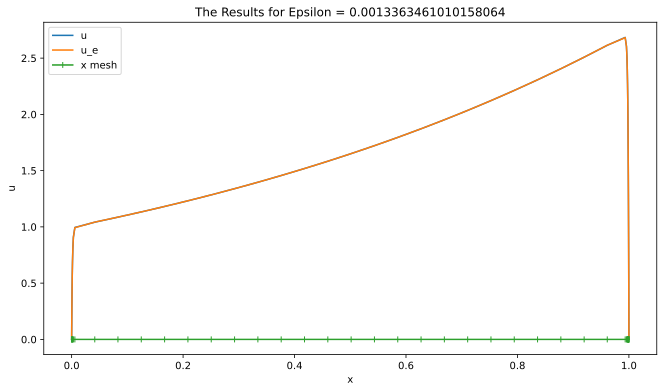



Epsilon continuation checks
norm(x) =  0.7208954565585444
norm(u) =  1.61979010594048



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0010022595757618548 MESH TOLERANCE FOR MP-ITERATION IS 0.00010022595757618548
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7208954565585444
norm(u) =  1.61979010594048



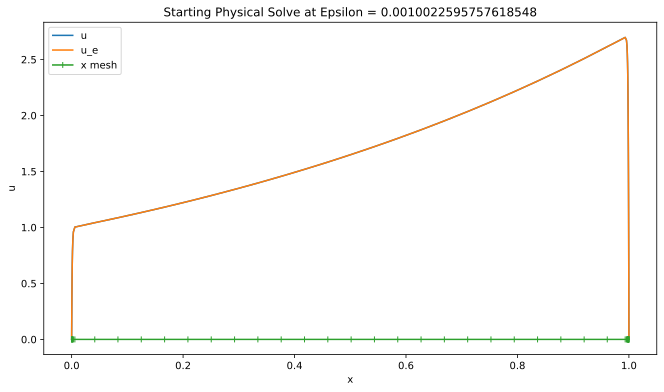



  0 SNES Function norm 1.266540564145e+00
  1 SNES Function norm 9.662937676755e-06
  0 SNES Function norm 1.420076106084e+00
  1 SNES Function norm 1.083432090931e-05
  0 SNES Function norm 1.522413259323e+00
  1 SNES Function norm 1.161509138871e-05
  0 SNES Function norm 1.447555310090e+00
  1 SNES Function norm 1.104397055383e-05
  0 SNES Function norm 1.149231983220e+00
  1 SNES Function norm 8.767944197025e-06
  0 SNES Function norm 9.535167885263e-01
  1 SNES Function norm 7.274755773712e-06
  0 SNES Function norm 8.604807348304e-01
  1 SNES Function norm 6.564946953851e-06
  0 SNES Function norm 9.152964077666e-01
  1 SNES Function norm 6.983157414679e-06
  0 SNES Function norm 1.162814097124e+00
  1 SNES Function norm 8.871567551707e-06
  0 SNES Function norm 1.521981231556e+00
  1 SNES Function norm 1.161179532893e-05
  0 SNES Function norm 1.779209217801e+00
  1 SNES Function norm 1.357428905891e-05
  0 SNES Function norm 1.725289787890e+00
  1 SNES Function norm 1.3162916

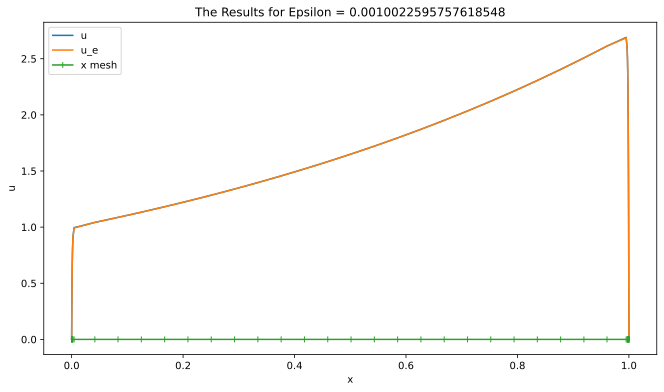



Epsilon continuation checks
norm(x) =  0.7210313647473187
norm(u) =  1.6195191471541035



In [5]:
# SET EPSILONS
epsilon = 0.1
eps_final = 1e-3
eps_change = 3/4
results = []

# PICARD DAMPING
w = 1/2

# MP STOPPING CRITERIA
max_MP_iters = 100


# FUNCTIONS TO SAVE RESULTS
u_save = Function(V_phys)
x_save = Function(V_mesh)


# M PARAMETERS (m=0 IS L2)
p = 2
q = 2
m = 0
exp_M = Constant( (2*q) / (1 + q*(2-m)) )
alpha_power = -3/4
alpha_scale = 5


# SET EXACT U
top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x)/(epsilon**2 - 1)
u_e = top/bottom - sub



# INITIAL GUESSES
x = Function(V_mesh).interpolate(SpatialCoordinate(xi_mesh)[0])
u = Function(V_phys).interpolate(x + 1/2)


# EPSILON CONTINUATION
##########################################################


while epsilon >= eps_final:


    mesh_convergence = False
    mesh_norms = []
    mesh_residuals = []
    mesh_tol = (1/10) * epsilon
    MP_Iter = 0


    print()
    print()
    print('-_'*100)
    print('EPSILON = ', epsilon, 'MESH TOLERANCE FOR MP-ITERATION IS', mesh_tol)
    print('-_'*100)
    print()
    print()


    # continuation checks
    print('Epsilon continuation checks')
    print("norm(x) = ", norm(x))
    print("norm(u) = ", norm(u))
    print()


    # STARTING PHYSICAL SOLVE AT NEW EPSILON ON OLD MESH

    # Test and Trial Functions
    u_new = TrialFunction(V_phys)
    v = TestFunction(V_phys)

    # Jacobian of x
    Jx = x.dx(0) #dx/dxi

    # Set the bilinear and linear forms of the weak form
    u_deriv = (1/Jx) * u_new.dx(0) # transform to du/dx
    v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
    a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u_new, v)) * Jx * dx # transform dxi to dx
    L = ( exp(x) ) * v * Jx * dx #transform dxi to dx

    # Set the BC's
    bcs = [DirichletBC(V_phys, Constant(0), 1), DirichletBC(V_phys, Constant(0), 2)]

    # Solve
    try:
      u_new = Function(V_phys).interpolate(u)
      solve( a==L, u_new, bcs = bcs, solver_parameters = lu_params)
    except Exception as e:
      print('The physical solve failed due to the following message:')
      print(e)
      print()

    # Update u
    u.dat.data[:] = u_new.dat.data[:]



    # exact u
    top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
    bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
    sub = exp(x)/(epsilon**2 - 1)
    u_e = top/bottom - sub

    # plot
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u).dat.data[perm_x], label = 'u')
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u_e).dat.data[perm_x], label = 'u_e')
    plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = '|', label = 'x mesh')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Starting Physical Solve at Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()



    # MP ITERATION
    ##############################################################



    while not(mesh_convergence):

        MP_Iter += 1



        # Check Max iterations
        if MP_Iter > max_MP_iters:
          print()
          print('MAX MP ITERATIONS REACHED SO WE BREAK!')
          print('THE LAST 5 MESH NORMS ARE:', end = "  ")
          print(mesh_norms[-5:])
          print()
          break




        # MESH DENSITY FUNCTION



        # Compute u'
        Jx = x.dx(0)
        upr_f = (1/Jx) * u.dx(0)
        # Compute u''
        u_pr_xi = u.dx(0)
        u_prpr_xi = u_pr_xi.dx(0)
        x_prpr_xi = Jx.dx(0)
        u_prpr = ( u_prpr_xi -  upr_f * x_prpr_xi) * (( 1/Jx )**2)

        # Compute M
        alpha_hat = alpha_scale * epsilon ** (alpha_power)
        # alpha_term1 = float(alpha_hat * sqrt(assemble(u_e*u_e* Jm * dx)))
        M = ( 1 + (1/alpha_hat) * abs(u_prpr) )**exp_M



        # MESH RESIDUAL
        vr = TestFunction(V_mesh)
        residual = Cofunction(V_mesh.dual())
        assemble(inner(M * x.dx(0), vr.dx(0))*dx, tensor=residual)
        mesh_residuals.append(norm(residual.riesz_representation()))



        # LINEAR MESH SOLVE




        # set solution and test function
        new_x = Function(V_mesh)
        vm = TestFunction(V_mesh)


        # jacobian
        Jm = new_x.dx(0) #dx/dxi

        # v'
        v_pr_term = (vm).dx(0)

        # the lhs of the eqn
        F = (M * Jm * v_pr_term) * dx




        # bc's
        bc0 = DirichletBC(V_mesh, Constant(0), 1)
        bc1 = DirichletBC(V_mesh, Constant(1), 2)
        bcs = [bc0, bc1]

        # initial guess
        new_x.dat.data[:] = x.dat.data[:]

        # The actual solve
        try:
          solve( F == 0, new_x, bcs = bcs, solver_parameters=mesh_params)
        except Exception as e:
          print('MESH SOLVE FAILED BECAUSE ', e)
          print()
          print()
          break


        # check mesh convergence
        mesh_norm = errornorm(new_x, x)
        mesh_norms.append(mesh_norm)

        if mesh_norm <= mesh_tol: # then the meshes have converged
          print()
          print('SINCE MESH TOLERANCE = ', mesh_norm, "WE HAVE MESH CONVERGENCE IN", MP_Iter, "MP ITERATIONS")
          print()
          mesh_convergence = True



        # update our x
        x.interpolate( (1-w) * x + w * new_x)




        # LINEAR PHYSICAL SOLVE




        # Test and Trial Functions
        u_new = TrialFunction(V_phys)
        v = TestFunction(V_phys)

        # Jacobian of x
        Jx = x.dx(0) #dx/dxi

        # Set the bilinear and linear forms of the weak form
        u_deriv = (1/Jx) * u_new.dx(0) # transform to du/dx
        v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
        a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u_new, v)) * Jx * dx # transform dxi to dx
        L = ( exp(x) ) * v * Jx * dx #transform dxi to dx

        # Set the BC's
        bcs = [DirichletBC(V_phys, Constant(0), 1), DirichletBC(V_phys, Constant(0), 2)]

        # Solve
        try:
          u_new = Function(V_phys).interpolate(u)
          solve( a==L, u_new, bcs = bcs, solver_parameters = lu_params)
        except Exception as e:
          print('The physical solve failed due to the following message:')
          print(e)
          print()
          break

        # Update u
        u.dat.data[:] = u_new.dat.data[:]




    # L2 AND ENERGY NORM FOR RESULT OF CURRENT EPSILON



    print()
    print('_'*100)
    print('RESULTS')
    print('_'*100)
    print()


    print("MESH RESIDUALS:")
    for r in mesh_residuals:
      print(r, end = ", ")
    print()
    print()


    print("ERRORS:")

    # Exact Solution
    top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
    bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
    sub = exp(x)/(epsilon**2 - 1)
    u_e = top/bottom - sub

    # L^2 error
    Jx = x.dx(0)
    error_val = (u - u_e)
    L2_error = norm(error_val * (sqrt(abs(Jx))))
    print("L2 error is", L2_error)

    # Energy norm error
    # (\eps^2 || u' ||_0^2 + || u ||_0^2 ) ^{1/2}
    u_approx_pr = (1/Jx) * u.dx(0)
    u_exact_pr = (1/Jx) * u_e.dx(0)
    u_pr_error = (u_approx_pr - u_exact_pr)
    L2_pr = norm(u_pr_error * (sqrt(abs(Jx))))
    energy_error =  float(sqrt( (epsilon**2) * (L2_pr**2) + (L2_error**2) ))
    print("Energy norm error is", energy_error)
    print()



    # SAVE AND PLOT THE RESULTS FOR THE CURRENT EPSILON

    # save
    u_save.dat.data[:] = u.dat.data[:]
    x_save.dat.data[:] = x.dat.data[:]
    results.append([epsilon, L2_error, energy_error, u_save, x_save])

    print('PLOTS:')

    # plot
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u).dat.data[perm_x], label = 'u')
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u_e).dat.data[perm_x], label = 'u_e')
    plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = '|', label = 'x mesh')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('The Results for Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()


    # UPDATE EPSILON
    epsilon = epsilon * eps_change


    # continuation checks
    print('Epsilon continuation checks')
    print("norm(x) = ", norm(x))
    print("norm(u) = ", norm(u))
    print()


